# 강화학습 모델 생성

## 데이터 선언

In [1]:
from scipy.io import loadmat
import numpy as np
np.set_printoptions(formatter={'float': '{:0.5f}'.format})

import pandas as pd

# .mat 파일 로드
data = loadmat('pvLoadPriceData_test.mat')

# 데이터 추출 예시
# MATLAB 파일 내에 있는 변수 이름을 정확히 알아야 합니다. time, cloudyDay, clearDay, loadData, costData
time = data['time'].flatten()
solarData = data['clearDay'].flatten()  # [kW]
loadData = data['loadData'][:, 2].flatten() * 10e-5   # [kW]
costData = data['costData'].flatten() * 300/3600

print("자료형:", type(time), "차원" , time.shape, )
print("자료형:", type(solarData), "차원" , solarData.shape, )
print("자료형:", type(loadData), "차원" , loadData.shape, )
print("자료형:", type(costData), "차원" , costData.shape, )

자료형: <class 'numpy.ndarray'> 차원 (228,)
자료형: <class 'numpy.ndarray'> 차원 (228,)
자료형: <class 'numpy.ndarray'> 차원 (228,)
자료형: <class 'numpy.ndarray'> 차원 (228,)


## 수전해 함수 선언

In [2]:
def P2G(power_kW, time_hours=1):
    """
    잉여 전력[kW] -> 수소 가스[Kg]
    """
    efficiency = 0.7  # Efficiency of the process
    heating_value_hydrogen = 33.33  # Heating value of hydrogen in kWh/kg

    hydrogen_produced_kg = (power_kW * time_hours * efficiency * heating_value_hydrogen) / 1000
    return hydrogen_produced_kg

# Example usage:
power = 100  # Power in kW

# Calculate hydrogen production for 1 hour
hydrogen_output = P2G(power)
print(f"Produced hydrogen: {hydrogen_output:.5f} kg")

Produced hydrogen: 2.33310 kg


In [3]:
# 남은 수소를 다시 잉여 전력으로
def P2Ga(hydrogen_produced_kg, time_hours=1):
    """
    남은 수소 가스를 다시 잉여 전력으로 변환
    """
    efficiency = 0.7  # Efficiency of the process
    heating_value_hydrogen = 33.33  # Heating value of hydrogen in kWh/kg

    power_kW = (hydrogen_produced_kg * 1000) / (time_hours * efficiency * heating_value_hydrogen)
    return power_kW

# Example usage:
power = 2.33310  # Power in kW

# Calculate hydrogen production for 1 hour
hydrogen_output = P2Ga(power)
print(f"Produced hydrogen: {hydrogen_output:.5f} kWh")

Produced hydrogen: 100.00000 kWh


In [4]:
# 수소 -> 전력
def G2P(hydrogen_kg):
    """
    Calculate the amount of electricity produced from hydrogen using a PEM fuel cell.

    Parameters:
    hydrogen_kg (float): The amount of hydrogen used in kilograms.
    fuel_cell_efficiency (float): The efficiency of the fuel cell (0-1).

    Returns:
    float: The amount of electricity produced in kilowatt-hours.
    """
    efficiency = 0.5  # Efficiency of the fuel cell

    heating_value_hydrogen = 33.33  # Heating value of hydrogen in kWh/kg
    electricity_produced_kWh = heating_value_hydrogen * efficiency * hydrogen_kg
    return electricity_produced_kWh

# Example usage:
hydrogen_amount = 2.33310  # Amount of hydrogen in kg
# Calculate electricity production
electricity_output = G2P(hydrogen_amount)
print(f"Electricity produced: {electricity_output:.5f} kWh")

Electricity produced: 38.88111 kWh


In [5]:
# 가스를 수소로 바꿨을 때 x만큼 필요함. 얼만큼의 수소를 쓸지 계산할 때
def G2Pa(tNeedPower):
    """
    X의 전력을 내기 위해 수소 탱크에서 필요한 수소[kg]\n
    필요한 수소[kg] = 전력 / (33.33 * 0.5)
    """
    efficiency = 0.5  # Efficiency of the fuel cell

    heating_value_hydrogen = 33.33  # Heating value of hydrogen in kWh/kg
    tNeedHydrogen = tNeedPower / (heating_value_hydrogen * efficiency) 
    return tNeedHydrogen

# Example usage:
hydrogen_amount = 38.88111 # Amount of hydrogen in kg
# Calculate electricity production
electricity_output = G2Pa(hydrogen_amount)
print(f"Electricity produced: {electricity_output:.5f} Kg")

Electricity produced: 2.33310 Kg


## 강화학습 환경 설정

In [6]:
import numpy as np
import gym
from gym import spaces

# 전력망 환경 클래스 정의
class PowerGridEnv(gym.Env):
    def __init__(self):
        self.solar_data = solarData
        self.load_data = loadData
        self.price_data = costData

        self.HydroCap = 100  # 수소 저장 장치 용량 [kg]
        HydrogenEnergyDensity = 33.33 # 수소 1Kg 당 [kWh]
        self.HydrogenEnergy = self.HydroCap * HydrogenEnergyDensity # 총 에너지 용량
        
        self.Hydrogen = 0.5 * self.HydroCap
        self.HydrogenMin = 0.2 * self.HydroCap
        self.HydrogenMax = 0.9 * self.HydroCap

        self.total_grid_cost = 0
        self.state = None

        # 배터리 상태
        self.observation_space = spaces.Box(low=np.array([0]), high=np.array([100]))
        
        # 액션 종류
        self.action_space = spaces.Discrete(7)
        self.data_pointer = 0
        

    def reset(self):
        self.data_pointer = 0
        self.Hydrogen = 0.5 * self.HydroCap  # 수소 가스 상태
        self.total_grid_cost = 0
        action = 0
        reward = 0
        done = False

        tP2G = 0
        tG2P = 0
        tNeedPower = 0

        self.state = [self.solar_data[0], self.load_data[0], (self.Hydrogen/self.HydroCap) * 100, (tP2G/self.HydroCap) * 100, ((-tG2P/self.HydroCap) * 100), action, self.total_grid_cost]
        return np.array(self.state), reward, done, {"cost" : self.total_grid_cost}

    
    def render(self, mode='human'):
        # 가정: self.state는 환경의 현재 상태를 나타냅니다.
        # 간단한 텍스트 출력으로 상태를 표현합니다.
        print(f"Current state: {self.state}")
        
    def step(self, action):
        reward = 0
       
        tPV = self.solar_data[self.data_pointer]    # 스탭 당 태양광 발전량
        tLoad = self.load_data[self.data_pointer]   # 스탭 당 부하량
        tPrice = self.price_data[self.data_pointer] # 스탭 당 전력 가격

        tP2G = 0
        tG2P = 0
        tNeedPower = 0

        # 액션에 따른 배터리 및 그리드 상호작용
        if action == 0 : # 태양광 O 수소 X 그리드 X
            if tPV >= tLoad :
                tSurplusPower = tPV - tLoad # 잉여 전력 계산 -> 잉여 전력이 있다면 수소로 변환 후 저장
                if tSurplusPower > 0 : 
                    # 수소 탱크의 충전 가능(kg)
                    # 최대 충전량 - 현재 충전량 = 충전 가능량
                    tPossible_Hydrogen = self.HydrogenMax - self.Hydrogen

                    # Power[kW] to Gas[kg]
                    tP2G = P2G(tSurplusPower) # 잉여 전력 -> 수소 가스로 변환
                    
                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(tP2G, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = tP2G - tPowerChg # 충전하고 남은 가스량
                    tP2G = tPowerChg
                    
                    # 배터리를 충전했을 때 20~80% 일 때
                    if ((self.Hydrogen + tPowerChg) > self.HydrogenMin) and ((self.Hydrogen + tPowerChg) < self.HydrogenMax) :
                        self.Hydrogen += tPowerChg
                    # 배터리를 충전했을 때 80% 이상일 때
                    else :
                        self.Hydrogen += tPowerChg
                        self.total_grid_cost -= P2Ga(tSurplusChg) * tPrice
                        reward = -P2Ga(tSurplusChg) * tPrice

            else : # tLoad > tPV
                # 태양광 발전량으로 커버한 뒤 필요한 전력을 계산
                tNeedPower = tLoad - tPV
                tG2P = G2Pa(tNeedPower) # 필요한 수소 가스 계산[kg]

                # 수소 탱크의 방전 가능(%)
                tPossible_Hydrogen = self.Hydrogen - self.HydrogenMin

                # 수소 텡크에서 사용할 양(L) 계산
                tPowerDisChg = min(tG2P, tPossible_Hydrogen) # 필요한 전력이랑 배터리 뱡젼 가능량을 비교해서 더 작은 값을 방전
                tSurplusChg = tG2P - tPowerDisChg # 충전하고 남은 수소[kg]
                tG2P = tPowerDisChg
                                
                # 배터리를 방전했을 때 20~80% 일 때
                if ((self.Hydrogen - tPowerDisChg) > self.HydrogenMin) and ((self.Hydrogen - tPowerDisChg) < self.HydrogenMax) :
                    self.Hydrogen -= tPowerDisChg
                # 배터리를 방전했을 때 20% 이하일 때
                else :
                    self.Hydrogen -= tPowerDisChg
                    self.total_grid_cost += G2P(tSurplusChg) * tPrice
                    reward = G2P(tSurplusChg) * tPrice


        elif action == 1 : # 태양광 O 수소 O 그리드 X
            if tLoad > tPV :
                # 태양광 발전량으로 커버한 뒤 필요한 전력을 계산
                tNeedPower = tLoad - tPV
                tG2P = G2Pa(tNeedPower) # 필요한 수소 가스 계산[kg]

                # 수소 탱크의 방전 가능(%)
                tPossible_Hydrogen = self.Hydrogen - self.HydrogenMin

                # 수소 텡크에서 사용할 양(L) 계산
                tPowerDisChg = min(tG2P, tPossible_Hydrogen) # 필요한 전력이랑 배터리 뱡젼 가능량을 비교해서 더 작은 값을 방전
                tSurplusChg = tG2P - tPowerDisChg # 방전하고 남은 전력량
                tG2P = tPowerDisChg

                # 배터리를 방전했을 때 20~80% 일 때
                if ((self.Hydrogen - tPowerDisChg) > self.HydrogenMin) and ((self.Hydrogen - tPowerDisChg) < self.HydrogenMax) :
                    self.Hydrogen -= tPowerDisChg
                # 배터리를 방전했을 때 20% 이하일 때
                else :
                    self.Hydrogen -= tPowerDisChg
                    self.total_grid_cost += G2P(tSurplusChg) * tPrice
                    reward = G2P(tSurplusChg) * tPrice


            else : # tLoad < tPV 
                tSurplusPower = tPV - tLoad # 잉여 전력 계산 -> 잉여 전력이 있다면 수소로 변환 후 저장
                if tSurplusPower > 0 : 
                    # Power[kW] to Gas[kg]
                    tP2G = P2G(tSurplusPower) # 잉여 전력 -> 수소 가스로 변환
                    
                    # 수소 탱크의 충전 가능(kg)
                    tPossible_Hydrogen = self.HydrogenMax - self.Hydrogen

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(tP2G, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = tP2G - tPowerChg # 충전하고 남은 전력량
                    tP2G = tPowerChg
                    
                    # 배터리를 충전했을 때 20~80% 일 때
                    if ((self.Hydrogen + tPowerChg) > self.HydrogenMin) and ((self.Hydrogen + tPowerChg) < self.HydrogenMax) :
                        self.Hydrogen += tPowerChg
                    # 배터리를 충전했을 때 80% 이상일 때
                    else :
                        self.Hydrogen += tPowerChg
                        self.total_grid_cost -= P2Ga(tSurplusChg) * tPrice
                        reward = -P2Ga(tSurplusChg) * tPrice

    
        elif action == 2 : # 태양광 O 수소 X 그리드 O
            if tLoad > tPV :
                tNeedPower = tLoad - tPV # 태양광 발전량으로 커버한 뒤 필요한 전력을 계산
                if tNeedPower > 0 : # 전력이 더 필요할 경우
                    self.total_grid_cost += tNeedPower * tPrice
                    reward = tNeedPower * tPrice

            else : # tLoad < tPV 
                tSurplusPower = tPV - tLoad # 잉여 전력 계산 -> 잉여 전력이 있다면 수소로 변환 후 저장
                if tSurplusPower > 0 : 
                    # Power[kW] to Gas[kg]
                    tP2G = P2G(tSurplusPower) # 잉여 전력 -> 수소 가스로 변환
                    
                    # 수소 탱크의 충전 가능(kg)
                    tPossible_Hydrogen = self.HydrogenMax - self.Hydrogen

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(tP2G, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = tP2G - tPowerChg # 충전하고 남은 전력량
                    tP2G = tPowerChg
                    
                    # 배터리를 충전했을 때 20~80% 일 때
                    if ((self.Hydrogen + tPowerChg) > self.HydrogenMin) and ((self.Hydrogen + tPowerChg) < self.HydrogenMax) :
                        self.Hydrogen += tPowerChg
                    # 배터리를 충전했을 때 80% 이상일 때
                    else :
                        self.Hydrogen += tPowerChg
                        self.total_grid_cost -= P2Ga(tSurplusChg) * tPrice
                        reward = -P2Ga(tSurplusChg) * tPrice


        elif action == 3 : # 태양광 O 수소 O 그리드 O
            if tLoad > tPV :
                # 태양광 발전량으로 커버한 뒤 필요한 전력을 계산
                tNeedPower = tLoad - tPV
                tG2P = G2Pa(tNeedPower) # 필요한 수소 가스 계산[kg]

                # 수소 탱크의 방전 가능(%)
                tPossible_Hydrogen = self.Hydrogen - self.HydrogenMin

                # 수소 텡크에서 사용할 양(L) 계산
                tPowerDisChg = min(tG2P, tPossible_Hydrogen) # 필요한 전력이랑 배터리 뱡젼 가능량을 비교해서 더 작은 값을 방전
                tSurplusChg = tG2P - tPowerDisChg # 충전하고 남은 전력량
                tG2P = tPowerDisChg
                
                # 배터리를 방전했을 때 20~80% 일 때
                if ((self.Hydrogen - tPowerDisChg) > self.HydrogenMin) and ((self.Hydrogen - tPowerDisChg) < self.HydrogenMax) :
                    self.Hydrogen -= tPowerDisChg
                # 배터리를 방전했을 때 20% 이하일 때
                else :
                    self.Hydrogen -= tPowerDisChg
                    self.total_grid_cost += G2P(tSurplusChg) * tPrice
                    reward = G2P(tSurplusChg) * tPrice
             

            else : # tLoad < tPV 
                tSurplusPower = tPV - tLoad # 잉여 전력 계산 -> 잉여 전력이 있다면 수소로 변환 후 저장
                if tSurplusPower > 0 : 
                    # Power[kW] to Gas[kg]
                    tP2G = P2G(tSurplusPower) # 잉여 전력 -> 수소 가스로 변환
                    
                    # 수소 탱크의 충전 가능(kg)
                    tPossible_Hydrogen = self.HydrogenMax - self.Hydrogen

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(tP2G, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = tP2G - tPowerChg # 충전하고 남은 전력량
                    tP2G = tPowerChg
                    
                    # 배터리를 충전했을 때 20~80% 일 때
                    if ((self.Hydrogen + tPowerChg) > self.HydrogenMin) and ((self.Hydrogen + tPowerChg) < self.HydrogenMax) :
                        self.Hydrogen += tPowerChg
                    # 배터리를 충전했을 때 80% 이상일 때
                    else :
                        self.Hydrogen += tPowerChg
                        self.total_grid_cost -= P2Ga(tSurplusChg) * tPrice
                        reward = -P2Ga(tSurplusChg) * tPrice
                            

        elif action == 4 : # 태양광 X 수소 O 그리드 X
            if tLoad > tPV :
                # 필요한 수소 가스 계산[kg]
                tG2P = G2Pa(tLoad)
                # 수소 탱크의 방전 가능(%)
                tPossible_Hydrogen = self.Hydrogen - self.HydrogenMin

                # 수소 텡크에서 사용할 양(L) 계산
                tPowerDisChg = min(tG2P, tPossible_Hydrogen) # 필요한 전력이랑 배터리 뱡젼 가능량을 비교해서 더 작은 값을 방전
                tSurplusChg = tG2P - tPowerDisChg # 충전하고 남은 전력량
                tG2P = tPowerDisChg

                # 배터리를 방전했을 때 20~80% 일 때
                if ((self.Hydrogen - tPowerDisChg) > self.HydrogenMin) and ((self.Hydrogen - tPowerDisChg) < self.HydrogenMax) :
                    self.Hydrogen -= tPowerDisChg
                # 배터리를 방전했을 때 20% 이하일 때
                else :
                    self.Hydrogen -= tPowerDisChg
                    self.total_grid_cost += G2P(tSurplusChg) * tPrice
                    reward = G2P(tSurplusChg) * tPrice
            
            else : # tLoad < tPV 
                tSurplusPower = tPV - tLoad # 잉여 전력 계산 -> 잉여 전력이 있다면 수소로 변환 후 저장
                if tSurplusPower > 0 : 
                    # Power[kW] to Gas[kg]
                    tP2G = P2G(tSurplusPower) # 잉여 전력 -> 수소 가스로 변환
                    
                    # 수소 탱크의 충전 가능(kg)
                    tPossible_Hydrogen = self.HydrogenMax - self.Hydrogen

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(tP2G, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = tP2G - tPowerChg # 충전하고 남은 전력량
                    tP2G = tPowerChg
                    
                    # 배터리를 충전했을 때 20~80% 일 때
                    if ((self.Hydrogen + tPowerChg) > self.HydrogenMin) and ((self.Hydrogen + tPowerChg) < self.HydrogenMax) :
                        self.Hydrogen += tPowerChg
                    # 배터리를 충전했을 때 80% 이상일 때
                    else :
                        self.Hydrogen += tPowerChg
                        self.total_grid_cost -= P2Ga(tSurplusChg) * tPrice 
                        reward = -P2Ga(tSurplusChg) * tPrice 


        elif action == 5 : # 태양광 X 수소 X 그리드 O
            self.total_grid_cost += tLoad * tPrice
            reward = tLoad * tPrice


        elif action == 6 : # 태양광 X 수소 O 그리드 O
            if tLoad > tPV :
                # 필요한 수소 가스 계산[kg]
                tG2P = G2Pa(tLoad)
                # 수소 탱크의 방전 가능(%)
                tPossible_Hydrogen = self.Hydrogen - self.HydrogenMin

                # 수소 텡크에서 사용할 양(L) 계산
                tPowerDisChg = min(tG2P, tPossible_Hydrogen) # 필요한 전력이랑 배터리 뱡젼 가능량을 비교해서 더 작은 값을 방전
                tSurplusChg = tG2P - tPowerDisChg # 방전하고 필요한 전력량
                tG2P = tPowerDisChg

                # 배터리를 방전했을 때 20~80% 일 때
                if ((self.Hydrogen - tPowerDisChg) > self.HydrogenMin) and ((self.Hydrogen - tPowerDisChg) < self.HydrogenMax) :
                    self.Hydrogen -= tPowerDisChg
                # 배터리를 방전했을 때 20% 이하일 때
                else :
                    self.Hydrogen -= tPowerDisChg
                    self.total_grid_cost += G2P(tSurplusChg) * tPrice
                    reward = G2P(tSurplusChg) * tPrice
            
            else : # tLoad < tPV 
                tSurplusPower = tPV - tLoad # 잉여 전력 계산 -> 잉여 전력이 있다면 수소로 변환 후 저장
                if tSurplusPower > 0 : 
                    # Power[kW] to Gas[kg]
                    tP2G = P2G(tSurplusPower) # 잉여 전력 -> 수소 가스로 변환
                    
                    # 수소 탱크의 충전 가능(kg)
                    tPossible_Hydrogen = self.HydrogenMax - self.Hydrogen

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(tP2G, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = tP2G - tPowerChg # 충전하고 남은 전력량
                    tP2G = tPowerChg

                    # 배터리를 충전했을 때 20~80% 일 때
                    if ((self.Hydrogen + tPowerChg) > self.HydrogenMin) and ((self.Hydrogen + tPowerChg) < self.HydrogenMax) :
                        self.Hydrogen += tPowerChg
                    # 배터리를 충전했을 때 80% 이상일 때
                    else :
                        self.Hydrogen += tPowerChg
                        self.total_grid_cost -= P2Ga(tSurplusChg) * tPrice 
                        reward = -P2Ga(tSurplusChg) * tPrice 


        # 데이터 포인터 갱신
        if self.data_pointer >= len(self.solar_data) - 1:
            done = True
        else:
            done = False
            self.data_pointer += 1

        # reward = 1 if done else 0
        self.state = [tPV, tLoad, (self.Hydrogen/self.HydroCap) * 100, (tP2G/self.HydroCap) * 100, ((-tG2P/self.HydroCap) * 100), action, self.total_grid_cost]
        return np.array(self.state), reward, done, {"cost" : self.total_grid_cost}


# 환경 인스턴스 생성 및 초기화
env = PowerGridEnv()
state = env.reset()
done = False

print("    PV     Load    SOC(%)   충전량    방전량    액션   누적 비용")

while not done:
    action = env.action_space.sample()  # 무작위 액션
    state, reward, done, info = env.step(action)
    
    print("", state, "보상", reward)




    PV     Load    SOC(%)   충전량    방전량    액션   누적 비용
 [3.50000 0.52154 50.06949 0.06949 0.00000 1.00000 0.00000] 보상 0
 [3.51000 1.37357 50.11934 0.04985 0.00000 1.00000 0.00000] 보상 0
 [3.49000 2.28354 50.14748 0.02815 0.00000 6.00000 0.00000] 보상 0
 [3.45000 4.28575 49.89031 0.00000 -0.25717 6.00000 0.00000] 보상 0
 [3.45000 5.38219 49.56735 0.00000 -0.32296 6.00000 0.00000] 보상 0
 [3.47000 4.46139 49.29964 0.00000 -0.26771 6.00000 0.00000] 보상 0
 [3.47000 4.88668 49.00641 0.00000 -0.29323 6.00000 0.00000] 보상 0
 [3.49000 4.46139 48.94812 0.00000 -0.05829 1.00000 0.00000] 보상 0
 [3.45000 4.88668 48.86191 0.00000 -0.08621 1.00000 0.00000] 보상 0
 [3.45000 4.46139 48.59420 0.00000 -0.26771 4.00000 0.00000] 보상 0
 [3.47000 4.88668 48.59420 0.00000 0.00000 2.00000 9.03136] 보상 9.031356356497215
 [3.47000 3.49172 48.59290 0.00000 -0.00130 0.00000 9.03136] 보상 0
 [3.49000 4.46139 48.59290 0.00000 0.00000 2.00000 15.22396] 보상 6.192602740538723
 [3.47000 4.88668 48.29967 0.00000 -0.29323 6.00000 15.22396]

/opt/miniconda3/envs/DQN/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


## Q-learing 설정

In [7]:
import random
import matplotlib.pyplot as plt

# 환경 초기화
env = PowerGridEnv()
state_size = len(loadData)
action_size = env.action_space.n

q_table = np.zeros((state_size, action_size))
alpha = 0.05     # 학습률
gamma = 0.6    # 할인율
epsilon = 0.1   # 탐험률

cost_table = []
best_action_table = []
min_cost = float('inf')  # 최소 비용을 기록하기 위한 변수
random.seed(42)
# 학습 과정
for i in range(10000):
    num = 0
    action_table = []
    state = env.reset()
    done = False
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmin(q_table[num])

        action_table.append(action)

        next_state, reward, done, info = env.step(action)
        old_value = q_table[num, action]
        next_max = np.max(q_table[num])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[num, action] = new_value
        num += 1

        # 비용 최소화 조건 검사
        if done and info['cost'] < min_cost:
            min_cost = info['cost']
            best_action_table = action_table  # 최적 상태 갱신

    cost_table.append(next_state[6])


/opt/miniconda3/envs/DQN/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [8]:
q_table

array([[4.65669, 4.65640, 4.65639, ..., 4.65642, 7.79004, 4.65614],
       [12.40364, 12.40327, 12.40339, ..., 12.40369, 20.72162, 12.40304],
       [20.47586, 20.47640, 20.47640, ..., 20.47643, 34.15406, 20.47629],
       ...,
       [193.39441, 193.39441, 193.39441, ..., 193.39441, 193.39441,
        193.39441],
       [176.54882, 176.54882, 176.54882, ..., 176.54882, 176.54882,
        176.54882],
       [158.21138, 158.21138, 158.21138, ..., 158.21138, 158.21138,
        158.21138]])

In [9]:
min(cost_table)

13401.9026623987

Text(0, 0.5, 'Grid Price [$/kWh]')

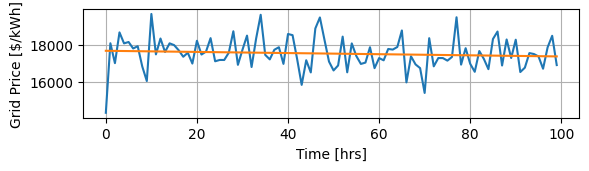

In [10]:
import matplotlib.pyplot as plt

# polyfit을 사용하여 추세선 계수를 계산
time = np.arange(len(cost_table[0::100]))
coefficients = np.polyfit(time, cost_table[0::100], 1)
# poly1d로 추세선 함수를 생성
trendline = np.poly1d(coefficients)


plt.subplot(3, 1, 1)
# Assuming C is grid price
plt.plot(time ,cost_table[0::100], time, trendline(time))
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Grid Price [$/kWh]')

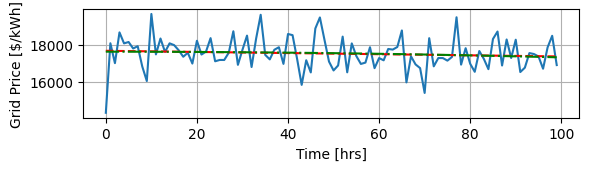

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# time 배열 생성 (인덱스를 시간으로 가정, 100개 간격으로 점프)
time = np.arange(len(cost_table[0::100]))

# 1차 다항식으로 추세선 계수 계산
coefficients_linear = np.polyfit(time, cost_table[0::100], 1)
# 2차 다항식으로 추세선 계수 계산
coefficients_quadratic = np.polyfit(time, cost_table[0::100], 2)

# poly1d로 추세선 함수 생성
trendline_linear = np.poly1d(coefficients_linear)
trendline_quadratic = np.poly1d(coefficients_quadratic)

# 데이터 및 추세선 플롯
plt.subplot(3, 1, 1)
plt.plot(time, cost_table[0::100], label='Grid Price Data')
plt.plot(time, trendline_linear(time), label='Linear Trend', linestyle='--', color='red')
plt.plot(time, trendline_quadratic(time), label='Quadratic Trend', linestyle='-.', color='green')

# 그리드, 레이블, 범례 설정
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Grid Price [$/kWh]')

plt.show()


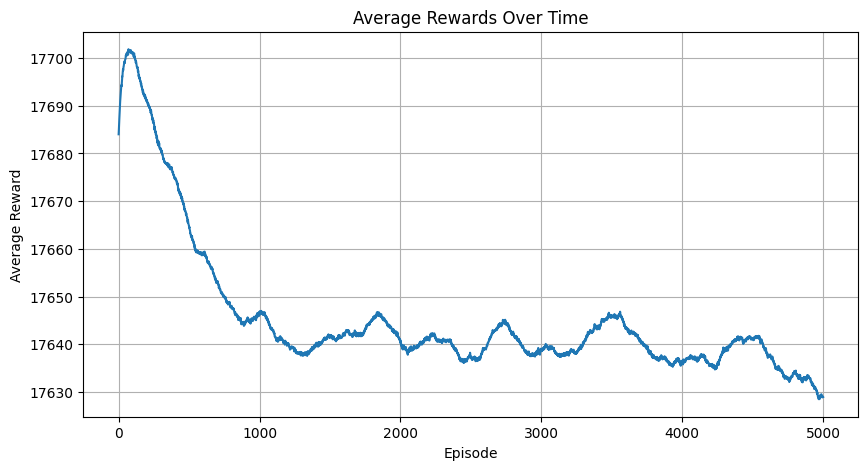

In [12]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# 보상의 이동 평균 계산
moving_avg_rewards = moving_average(cost_table, 5000)  # 50 에피소드 평균

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(moving_avg_rewards)
plt.title('Average Rewards Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.grid(True)
plt.show()


In [13]:
done = False
num = 0
env.reset()
cost = 0
while not done:
    action = best_action_table[num]

    state, reward, done, _ = env.step(action)
    num += 1
    cost += reward
    env.render()

Current state: [3.5, 0.521540859602613, 50.06949043020461, 0.06949043020461143, 0.0, 0, 0]
Current state: [3.51, 1.3735691502060512, 50.11933549836115, 0.04984506815654262, 0.0, 0, 0]
Current state: [3.49, 2.283542483980296, 50.14748335866741, 0.028147860306255712, 0.0, 6, 0]
Current state: [3.45, 4.285748439511477, 50.097333437304584, 0.0, -0.05014992136282489, 0, 0]
Current state: [3.45, 5.38219314050352, 49.981390254556096, 0.0, -0.11594318274848604, 0, 0]
Current state: [3.47, 4.461388665182545, 49.92190098571826, 0.0, -0.05948926883783647, 0, 0]
Current state: [3.47, 4.886683350038779, 49.83689148376574, 0.0, -0.08500950195252198, 0, 0]
Current state: [3.49, 4.461388665182545, 49.778602334939904, 0.0, -0.05828914882583528, 0, 0]
Current state: [3.45, 4.886683350038779, 49.69239271297538, 0.0, -0.08620962196452318, 0, 0]
Current state: [3.45, 4.461388665182545, 49.631703324125546, 0.0, -0.06068938884983767, 0, 0]
Current state: [3.47, 4.886683350038779, 49.546693822173026, 0.0, -0.